# Basic regression modeling example

This Notebook will walk through building a linear regression using Sklearn, with appropriate data exploration and model plotting. It makes use of re-usable functions for various data and model exploration capabilities stored within .py files in the /utilities/ folder.

**Table of contents**

- **<a href="#data_import_overview">Data import and overview</a>**
- **<a href="#bivariate_exploration">Bivariate exploration</a>**
	- <a href="#correlation_analysis">Correlation analysis</a>
	- <a href="#scatterplots">Scatterplots</a>
	- <a href="#bivariate_plots">Bivariate plots</a>
- **<a href="#data_transformation_train_test_split">Data transformations</a>**
	- <a href="#train_test_split">Train-test split for model training</a>
- **<a href="#feature_selection">Feature selection for OLS regression</a>**
	- <a href="#manual_selection_variables">Manual selection of variables</a>
	- <a href="#stepwise_selection_variables">Stepwise selection of variables</a>
	- <a href="#subset_selection_variables">Subsets selection</a>
	- <a href="#lasso_selection_variables">LASSO for variable selection</a>
- **<a href="#analyze_models">Analyze candidate models</a>**
	- <a href="#model_performance_statistics">Model performance statistics</a>
	- <a href="#model_performance_plots">Model performance plots</a>
	- <a href="#statistical_tests_plots">Statistical tests and diagnostic plots</a>

**Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import itertools
from itertools import compress
import sklearn
from sklearn import datasets, model_selection, linear_model, metrics
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

**We also import our own re-usable functions located in the utilities folder**

In [2]:
# Load in OW color scheme and plot style
plt.style.use('../utilities/resources/ow_style.mplstyle')

# Add path of the folder 'resources' to the path from which we can import modules  
import sys
sys.path.append('../utilities')
from data_exploration import bivariate_plots
from regression_classification import model_plots, lasso_utilities, sklearn_regression
from resources.ow_colormap import ow_colormap 

<a id="data_import_overview"></a>

# Data import and overview

We make use of one of the toy datasets provided in the sklearn library. This file contains data from a diabetes-related medical study: 

*Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.*

For more information, refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html

**Load dataset into a pandas dataframe**

In [3]:
dataset = datasets.load_diabetes(as_frame=True).frame

**Review top rows of the dataset**

In [4]:
dataset.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


**Relabel the cryptic columns names s1-s6, and the target variable**

In [5]:
rename_columns = {
    "s1": "total_serum_cholesterol",
    "s2": "low_density_lipoproteins",
    "s3": "high_density_lipoproteins",
    "s4": "total_cholesterol_to_hdl_ratio",
    "s5": "log_serum_triglycerides_level",
    "s6": "blood_sugar_level",
    "target": "disease_progression"
}

dataset = dataset.rename(columns=rename_columns)

**Briefly describe the data**

In [6]:
dataset.describe()

,age,sex,bmi,bp,total_serum_cholesterol,low_density_lipoproteins,high_density_lipoproteins,total_cholesterol_to_hdl_ratio,log_serum_triglycerides_level,blood_sugar_level,disease_progression
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


As you see, the mean in this dataset is 0, and the standard deviation is the same across all variables. This indicates that the data has been standardized already. 

Some benefits of standardizing the data include:
* Coefficients from a regression are directly comparable with another, in order to assess magnitude of impact
* Able to perform regularized regression without worrying about standardizing the data up-front

But there are also drawbacks with using pre-standardized data compared to using the raw data (which you can choose to standardize when needed), especially if you do not have the information about the data to undo the standardization
* Difficult to make sense of each observation (e.g. what age corresponds to a value of 0.5?)  
* Unable to standardize new data for future predictions

**Plot several histograms to understand the distribution, especially how skewed each variable is**

In this case, we have 11 columns, and we are plotting it as a 3 x 4 grid of plots

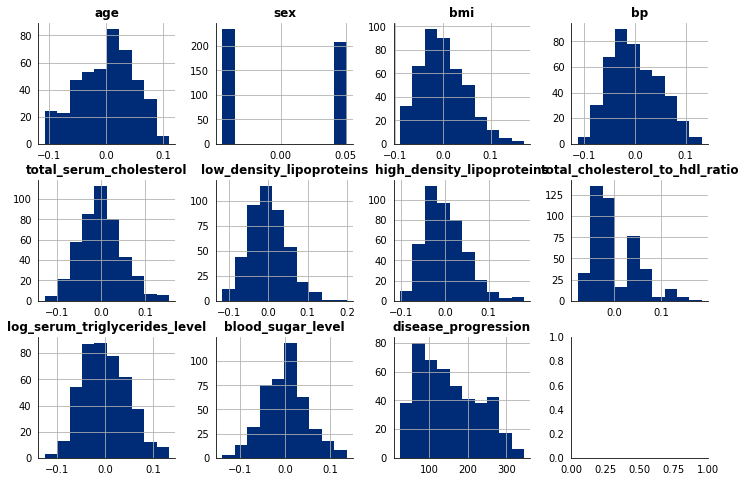

In [7]:
fig, ax = plt.subplots(3,4,figsize=(12, 8))
dataset.hist(ax=ax.flatten()[:11])
plt.show()

Overall, the distribution of the variables are fairly well-behaved, without any massive outliers

<a id="bivariate_exploration"></a>

# Bivariate exploration

This section provides additional exploratory analysis specially useful for regression modeling:
* Correlation analysis
* Scatter plots
* Bivariate plots

<a id="correlation_analysis"></a>
## Correlation analysis

Correlation analysis provide a measure of the strength of the relationship between two variables. We typically care about the correlations between each independent variable (x-variables) and the dependent (y-variable), but also the correlations among the independent variables as high correlations may result in multicollinearity and/or overfitting in the linear regression model.

There are different kinds of correlation metrics. The most common is "pearson" correlation which is the default option. Another useful one is "spearman's correlation" which measure extent of 'monotone' or 'directional' relationship.

We make use of the .corr() method in pandas, which ignores NaN values for each pair-wise comparison
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

**Pearson correlation**

In [8]:
dataset.corr()

,age,sex,bmi,bp,total_serum_cholesterol,low_density_lipoproteins,high_density_lipoproteins,total_cholesterol_to_hdl_ratio,log_serum_triglycerides_level,blood_sugar_level,disease_progression
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
total_serum_cholesterol,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
low_density_lipoproteins,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
high_density_lipoproteins,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
total_cholesterol_to_hdl_ratio,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
log_serum_triglycerides_level,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
blood_sugar_level,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


**Spearman correlation**

In [9]:
dataset.corr(method='spearman')

,age,sex,bmi,bp,total_serum_cholesterol,low_density_lipoproteins,high_density_lipoproteins,total_cholesterol_to_hdl_ratio,log_serum_triglycerides_level,blood_sugar_level,disease_progression
age,1.000000,0.177463,0.200554,0.350859,0.262524,0.221711,-0.106973,0.221017,0.265176,0.296235,0.197822
sex,0.177463,1.000000,0.098079,0.261508,0.027790,0.134695,-0.394584,0.337524,0.174625,0.203277,0.037401
bmi,0.200554,0.098079,1.000000,0.397985,0.287829,0.295494,-0.371172,0.459068,0.491609,0.384664,0.561382
bp,0.350859,0.261508,0.397985,1.000000,0.275224,0.205638,-0.191033,0.280799,0.396071,0.381219,0.416241
total_serum_cholesterol,0.262524,0.027790,0.287829,0.275224,1.000000,0.878793,0.015308,0.520674,0.512864,0.332173,0.232429
low_density_lipoproteins,0.221711,0.134695,0.295494,0.205638,0.878793,1.000000,-0.197435,0.652283,0.349947,0.286483,0.195834
high_density_lipoproteins,-0.106973,-0.394584,-0.371172,-0.191033,0.015308,-0.197435,1.000000,-0.789694,-0.450420,-0.290863,-0.410022
total_cholesterol_to_hdl_ratio,0.221017,0.337524,0.459068,0.280799,0.520674,0.652283,-0.789694,1.000000,0.640390,0.413700,0.448931
log_serum_triglycerides_level,0.265176,0.174625,0.491609,0.396071,0.512864,0.349947,-0.450420,0.640390,1.000000,0.453023,0.589416
blood_sugar_level,0.296235,0.203277,0.384664,0.381219,0.332173,0.286483,-0.290863,0.413700,0.453023,1.000000,0.350792


**Heatmap, useful for larger correlation matrices**

We apply two methods to visualize the correlation matrix generated using .corr():
* adding color gradient to the dataframe
* matplotlib's .imshow to generate a 2D heatmap in Matplotlib

There are better visualizations available in the seaborn library: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [10]:
with pd.option_context('display.precision', 2):
    plot = dataset.corr().style.background_gradient(cmap='coolwarm')
plot

,age,sex,bmi,bp,total_serum_cholesterol,low_density_lipoproteins,high_density_lipoproteins,total_cholesterol_to_hdl_ratio,log_serum_triglycerides_level,blood_sugar_level,disease_progression
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
total_serum_cholesterol,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
low_density_lipoproteins,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
high_density_lipoproteins,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
total_cholesterol_to_hdl_ratio,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
log_serum_triglycerides_level,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
blood_sugar_level,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


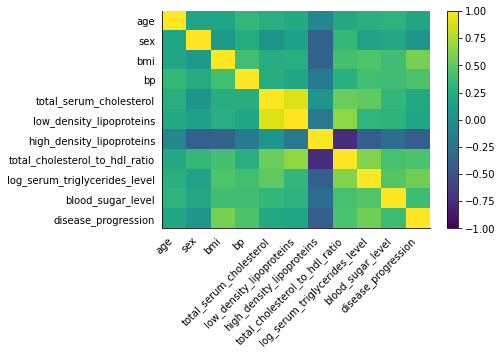

In [11]:
correlation = dataset.corr()

fig, ax = plt.subplots(1,1)
img = ax.imshow(correlation, cmap=ow_colormap('blue_orange'), interpolation='none', aspect='auto', vmax=1,vmin=-1)
plt.colorbar(img,ax=ax)

x_label_list = correlation.columns.values
y_label_list = correlation.index.values

ax.set_xticks(range(len(x_label_list)))
ax.set_xticklabels(x_label_list, rotation = 45, ha="right")
ax.set_yticks(range(len(y_label_list)))
ax.set_yticklabels(y_label_list)

plt.show()

<a id="scatterplots"></a>
## Scatterplots / 2D density plots

For datasets with relatively few variables, it can make sense to create scatterplots or density plots for every pair of variables, instead of summarizing the relationship into a single variable. This is particularly useful to identifying more complex relationships between variables, which is particularly helpful when developing linear regressions. 

**Scatterplot in a matrix grid**

Focusing on the last 5 independent variables and the target variable, we can create a 6 x 6 grid of scatterplots:
https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

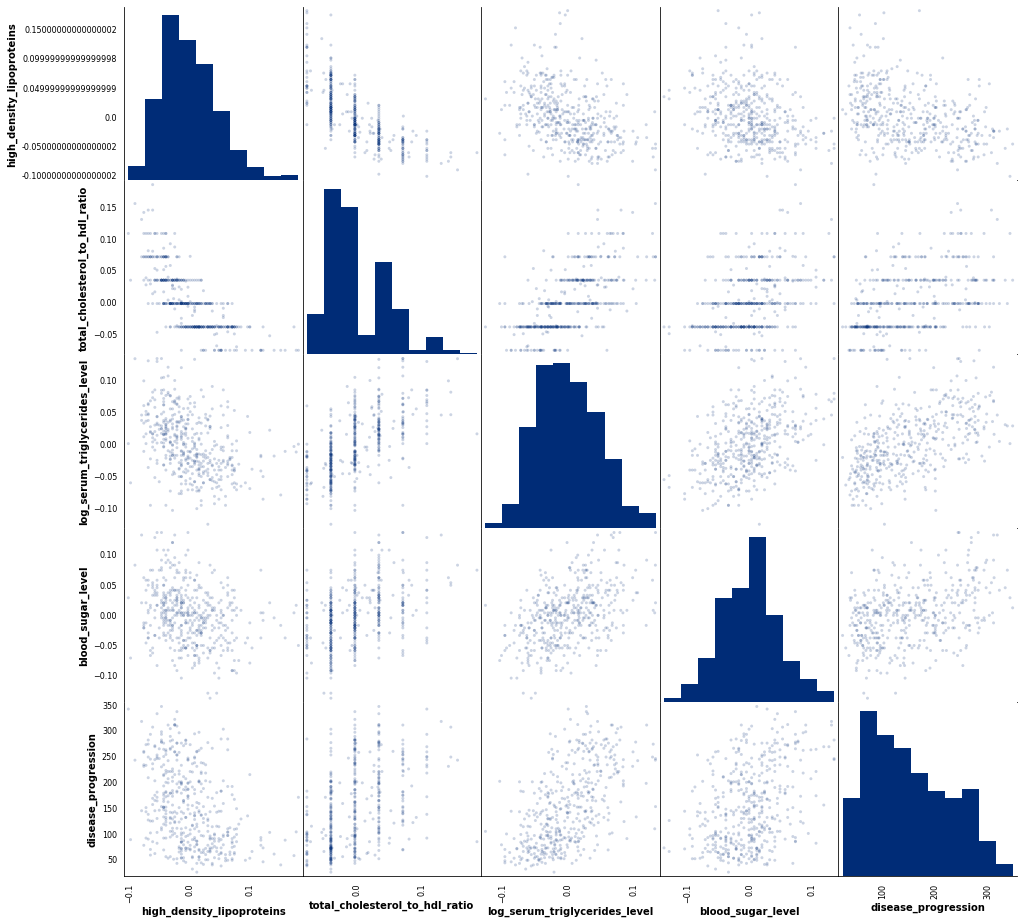

In [12]:
from pandas.plotting import scatter_matrix
_ = scatter_matrix(dataset.iloc[:,6:], alpha = 0.2, figsize = (16, 16), diagonal = 'hist')

**The seaborn package has a great pairplot function that offers a more flexible version of this matrix plot**

https://seaborn.pydata.org/generated/seaborn.pairplot.html

<a id="bivariate_plots"></a>
## Bivariate plots

Bivariate plots are great for more closely examining the relationship between a specific independent variable with the dependent (target) variable. In linear models, the assumption is that the dependent variable can be approximated as a linear combination of independent variables, and this typically means that the relationship between each independent variable and the dependent variable is mostly linear. 

(Note: it does not necessarily have to be linear in the 1 vs. 1 relationship, as the independent variable may be correlated with other variables in a multi-factor model)

**A scatterplot may be a decent starting point, but may be difficult to clearly determine the patterns given the many points in the figure**

Some improvement can be made by adding a best fit line to the chart.

We use matplotlib here, but the seaborn package offers a simpler way of accomplishing this, and allows for the inclusion of a lowess curve (curved fit): 
https://seaborn.pydata.org/generated/seaborn.regplot.html

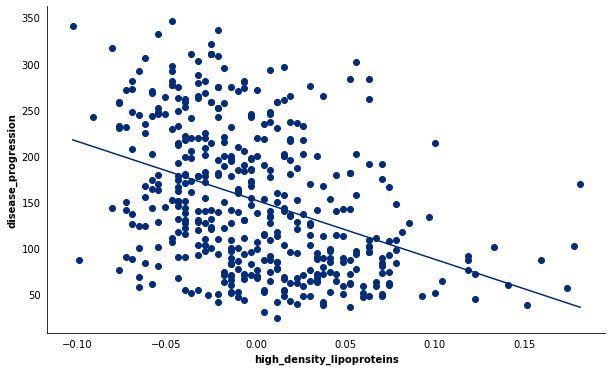

In [13]:
y = dataset['disease_progression']
x = dataset['high_density_lipoproteins']

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) # Best fit line
ax.set_xlabel("high_density_lipoproteins")
ax.set_ylabel("disease_progression")
plt.show()

**By plotting the data at a more aggregated level, the nature of the relationship can be made more clearly**

Here we are using our own function to group the data based on the value of the x-variable (by rank-order), and calculating the average y-value and x-value for the plot. This reduces the dispersion in individual observations and provides a cleaner view of the relationship. 

That said, since it reduces the dispersion among individual observations, a scatterplot is still valuable to gauge the 'uncertainty' around the bivariate relationship.

For more help on this function, write *help(bivariate_plots.bivariate_continuous)*

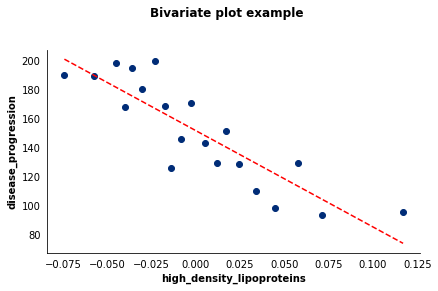

In [14]:
# Basic plot
plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                              y_var = "disease_progression", x_var = "high_density_lipoproteins", 
                                                              with_count = False, header = "Bivariate plot example",
                                                              trendline = True, num_buckets = 20)

**We can plot this with other choices of number of buckets, and also add standard deviations**

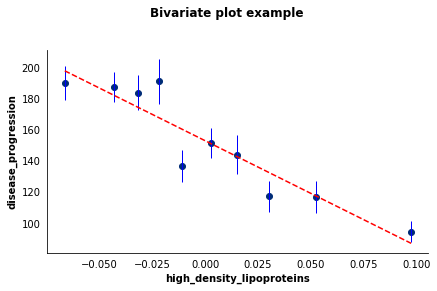

In [15]:
# Basic plot
plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                              y_var = "disease_progression", x_var = "high_density_lipoproteins", 
                                                              with_count = False, header = "Bivariate plot example",
                                                              trendline = True, num_buckets = 10, with_stderr=True)

This variable appears reasonably linear, with potentially diminishing effect below -0.05 and above 0.075. Keep in mind that this variable's range is from -0.10 to 0.17, so while the relationship appears linear in the aggregated plot, there may be reason to floor and cap this variable to avoid outliers having extreme predictions.

**We briefly look at another variable: age**

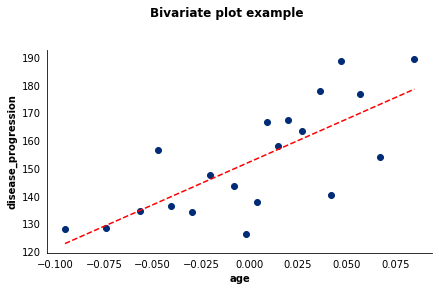

In [16]:
plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                              y_var = "disease_progression", x_var = "age", 
                                                              with_count = False, header = "Bivariate plot example",
                                                              trendline = True, num_buckets = 20)

The relationship with age is mostly linear, but potentially with a kink around 0. If we believe the slope changes around age = 0, then we can define an additional variable age_above_0 = max(0, age) that will capture the incremental marginal effect of age, for age > 0

<a id="data_transformation_train_test_split"></a>

# Data transformations and train-test split

We move ahead with two transformations mentioned above: 
* Floor and Cap the high_density_lipoproteins
* Adding an age variable for ages above 0

When we build the model, we will show the model without using these transformations, to illustrate how to identify whether linearity in the final model can be improved. 

In [17]:
dataset['hdl_floor_cap'] = dataset['high_density_lipoproteins'].clip(lower=-0.05, upper=0.10)
dataset['age_above_0'] = dataset['age'].apply(lambda x: max(x,0))

A scatter plot between the transformed and original variable provide insight into the transformation made, if it is not obvious from the formula already

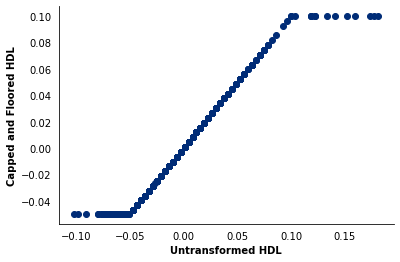

In [18]:
fig, ax = plt.subplots(1,1)
ax.scatter(x = dataset['high_density_lipoproteins'], y = dataset['hdl_floor_cap'])
ax.set_xlabel("Untransformed HDL")
ax.set_ylabel("Capped and Floored HDL")
plt.show()

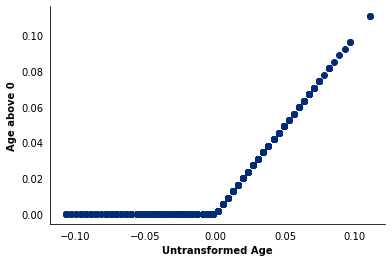

In [19]:
fig, ax = plt.subplots(1,1)
ax.scatter(x = dataset['age'], y = dataset['age_above_0'])
ax.set_xlabel("Untransformed Age")
ax.set_ylabel("Age above 0")
plt.show()

<a id="train_test_split"></a>

## Train-Test split

For model development, it is advisable to split the data into train vs. test, to check that the model has good generalizability. How the train-test split is done should mirror the current data vs. data that the model is expected to be used to predict on. In this case, a random sample of the dataset can be used.

In [20]:
all_x_variables = ['age', 'sex', 'bmi', 'bp', 'total_serum_cholesterol',
       'low_density_lipoproteins', 'high_density_lipoproteins',
       'total_cholesterol_to_hdl_ratio', 'log_serum_triglycerides_level',
       'blood_sugar_level', 'hdl_floor_cap', 'age_above_0']

x_variables_without_transformations = list(set(all_x_variables) - set(['hdl_floor_cap', 'age_above_0']))

X,y = dataset[all_x_variables], dataset['disease_progression']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=1000)

<a id="feature_selection"></a>
# Feature selection

It is rarely advisable to use all available independent variables in a regression due to risk of overfitting, multicollinearity, and unintuitive model effects. 

There are many ways to identify appropriate subsets of variables for use in a model. Some of these methods are described here:
* Manual selection based on intuition and hypothesis
* Stepwise selection: Beginning with an initial set of variables (potentially no variables, or all variables), consider potential adding / removing of individual independent variables
* Subset selection: Identify many different subsets of variables of different sizes (e.g. 100 2-variable models, 100 3-variable models)
* LASSO regression: Using regularized regression to identify variables

**We build several candidate models in this section, and in the next section analyze and compare these models**  

We use OLS linear regression provided by sklearn: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

<a id="manual_selection_variables"></a>
## Manual selection of variables

In [21]:
manual_variables = ['age', 'sex', 'bmi', 'bp', 'log_serum_triglycerides_level']

manual_model = linear_model.LinearRegression().fit(X_train[manual_variables], y_train)

<a id="stepwise_selection_variables"></a>
## Stepwise selection using sklearn's feature selection module

This uses the basic functionality offered in sklearn https://scikit-learn.org/stable/modules/feature_selection.html. There is more powerful functionality in mlxtend http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [22]:
lr = linear_model.LinearRegression()

# Sequential feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=5)
sfs.fit(X_train[x_variables_without_transformations], y_train)

stepwise_variables = list(compress(X_train[x_variables_without_transformations], sfs.support_))
stepwise_variables

['high_density_lipoproteins',
 'log_serum_triglycerides_level',
 'bmi',
 'sex',
 'bp']

In [23]:
# Build model with selected features
stepwise_model = lr.fit(X_train[stepwise_variables], y_train)

<a id="subset_selection_variables"></a>
## Subset selection

This approach considers all possible combinations of variables and selects the top K number of each. Note that this can only be run for datasets with a small number of variables to find models with few variables, to avoid the total number of variables from blowing up. This code is adapted from http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html to work with sklearn

There are more efficient algorithms that do not consider all possible combinations.

In [24]:
def processSubset(training_X, training_Y):
    # Fit model on feature_set and calculate Residual Sum of Squares
    regr = linear_model.LinearRegression().fit(training_X, training_Y)
    RSS = (np.array(regr.predict(training_X) - training_Y) ** 2).sum()
    return {"model":regr, "RSS":RSS, "Vars":"; ".join(training_X.columns.values), "num_vars": training_X.shape[1]}

def getBest(N_vars, top_models, training_X, training_Y):
    results = []
    for combo in itertools.combinations(training_X.columns, N_vars):
        results.append(processSubset(training_X[list(combo)], training_Y))
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_models = models.sort_values(["RSS"]).head(top_models)
    
    print("Processed", models.shape[0], "models on", N_vars, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_models

In [25]:
# Models with 1,2,3 variables, 10 of each

best_models = pd.concat([getBest(n, 10, X_train[x_variables_without_transformations], y_train) for n in [1,2,3]]).reset_index(drop=True)
best_models.sort_values(["RSS"])

Processed 10 models on 1 predictors
Processed 45 models on 2 predictors
Processed 120 models on 3 predictors


,model,RSS,Vars,num_vars
20,LinearRegression(),9.880503e+05,log_serum_triglycerides_level; bmi; bp,3
21,LinearRegression(),1.007740e+06,high_density_lipoproteins; log_serum_triglycer...,3
22,LinearRegression(),1.007870e+06,log_serum_triglycerides_level; bmi; total_seru...,3
23,LinearRegression(),1.009955e+06,log_serum_triglycerides_level; bmi; sex,3
24,LinearRegression(),1.010128e+06,log_serum_triglycerides_level; bmi; blood_suga...,3
25,LinearRegression(),1.016887e+06,log_serum_triglycerides_level; bmi; low_densit...,3
26,LinearRegression(),1.020254e+06,age; log_serum_triglycerides_level; bmi,3
27,LinearRegression(),1.020626e+06,total_cholesterol_to_hdl_ratio; log_serum_trig...,3
10,LinearRegression(),1.021786e+06,log_serum_triglycerides_level; bmi,2
28,LinearRegression(),1.101364e+06,total_cholesterol_to_hdl_ratio; bmi; bp,3


**Select preferred model based on intuition**

In [26]:
subsets_variables = ["log_serum_triglycerides_level","bmi","bp"]
subsets_model = linear_model.LinearRegression().fit(X_train[subsets_variables], y_train)

<a id="lasso_selection_variables"></a>
## LASSO selection

Regularized regression by penalizing the magnitude of model coefficients on a standardized dataset can be used to remove variables (as the penalty will force coefficients of less important variables to 0)

Here we make use of a wrapper function built around sklearn's Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html. You can find information about this function through *help(lasso_utilities.lasso_ols)*. 

In [27]:
lasso_df = lasso_utilities.lasso_ols(
    dataset=pd.concat([X_train, y_train], axis=1),    # Combine X and y data
    DV='disease_progression',
    IVs = x_variables_without_transformations,
    forced_in = list(), # No variables to be forced into every model
    intercept = True,
    alpha_list = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25]
)

lasso_df

,Alpha,Variables,Converged?,Rsq,Intercept,age Coef,total_cholesterol_to_hdl_ratio Coef,high_density_lipoproteins Coef,log_serum_triglycerides_level Coef,bmi Coef,sex Coef,total_serum_cholesterol Coef,bp Coef,blood_sugar_level Coef,low_density_lipoproteins Coef
0,0.001,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.519905,152.579288,1.735656,10.354866,6.823066,34.915528,26.542359,-13.314827,-35.722200,14.064303,5.730141,20.062967
1,0.010,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.519897,152.579288,1.727534,10.086576,6.111021,34.388723,26.547339,-13.286644,-34.214490,14.041117,5.738457,18.896165
2,0.100,age;total_cholesterol_to_hdl_ratio;log_serum_t...,True,0.519289,152.579288,1.637784,7.929060,0.000000,29.688420,26.611973,-13.007021,-20.875449,13.834427,5.805660,8.461485
3,0.250,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.518131,152.579288,1.444883,7.141939,-3.826330,25.908555,26.751907,-12.574412,-10.576353,13.636576,5.814689,0.000000
4,0.500,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.517644,152.579288,1.148404,5.113519,-5.229138,25.668916,26.611898,-12.030254,-8.818619,13.364657,5.710132,-0.000000
5,0.750,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.516832,152.579288,0.851944,3.083322,-6.633343,25.429205,26.471819,-11.486056,-7.059787,13.092666,5.605668,-0.000000
6,1.000,age;total_cholesterol_to_hdl_ratio;high_densit...,True,0.515697,152.579288,0.555478,1.053582,-8.037188,25.189513,26.331759,-10.941868,-5.301237,12.820694,5.501181,-0.000000
7,2.500,high_density_lipoproteins;log_serum_triglyceri...,True,0.508680,152.579288,0.000000,0.000000,-8.244587,23.403905,25.778062,-8.238130,-1.488613,11.502348,4.231921,-0.000000
8,5.000,high_density_lipoproteins;log_serum_triglyceri...,True,0.492316,152.579288,0.000000,0.000000,-6.029182,22.226900,25.261024,-3.814047,-0.000000,9.211109,2.454152,-0.000000
9,7.500,high_density_lipoproteins;log_serum_triglyceri...,True,0.470522,152.579288,0.000000,0.000000,-3.487137,21.777391,24.801467,-0.000000,-0.000000,7.063265,0.987411,-0.000000


**We select a model where R-squared does not materially improve with the number of additional variables added**

Index 7 appears like a good model. Below, we select the models and retrain an OLS regression. (An alternative would be to stick with the Lasso regression itself, which will be slightly different from the OLS regression)

In [28]:
lasso_variables = lasso_df.loc[7,'Variables'].split(';')
lasso_model = linear_model.LinearRegression().fit(X_train[lasso_variables], y_train)
lasso_variables

['high_density_lipoproteins',
 'log_serum_triglycerides_level',
 'bmi',
 'sex',
 'total_serum_cholesterol',
 'bp',
 'blood_sugar_level']

<a id="analyze_models"></a>

# Analyze models

This calculates key performance statistics for each model, and for a selected model provides further deepdives.

<a id="model_performance_statistics"></a>

## Model performance statistics

R2, Adjusted R2, RMSE, MAPE statistics

In [29]:
def get_stats(regression, X, y, scores = ["r2", "adj_r2", "rmse", "mape"]):
    
    pred = regression.predict(X)
    results = {}
    
    results['variables'] = "; ".join(X.columns.values)
    if "r2" in scores:
        results['r2'] = metrics.r2_score(y_true=y, y_pred=pred)
    if "adj_r2" in scores:
        n = X.shape[0]
        p = X.shape[1]
        results['adj_r2'] = 1-(1-results['r2'])*(n-1)/(n-p-1)
    if "rmse" in scores:
        results['rmse'] = np.sqrt(np.mean((pred - y)**2))
    if "mape" in scores:
        results['mape'] = np.mean(np.abs((y-pred)/pred))
        
    return results
        

**Generate performance statistics for train**

In [30]:
train_stats = pd.DataFrame({
    "manual": get_stats(manual_model, X_train[manual_variables], y_train),
    "stepwise": get_stats(stepwise_model, X_train[stepwise_variables], y_train),
    "subsets": get_stats(subsets_model, X_train[subsets_variables], y_train),
    "lasso": get_stats(lasso_model, X_train[lasso_variables], y_train),  
}).T
train_stats

,variables,r2,adj_r2,rmse,mape
manual,age; sex; bmi; bp; log_serum_triglycerides_level,0.491433,0.483041,55.90113,0.335552
stepwise,high_density_lipoproteins; log_serum_triglycer...,0.50808,0.499962,54.978644,0.314832
subsets,log_serum_triglycerides_level; bmi; bp,0.479612,0.474493,56.547095,0.340105
lasso,high_density_lipoproteins; log_serum_triglycer...,0.516386,0.505139,54.512499,0.313505


**Generate performance statistics for test data**

In [31]:
test_stats = pd.DataFrame({
    "manual": get_stats(manual_model, X_test[manual_variables], y_test),
    "stepwise": get_stats(stepwise_model, X_test[stepwise_variables], y_test),
    "subsets": get_stats(subsets_model, X_test[subsets_variables], y_test),
    "lasso": get_stats(lasso_model, X_test[lasso_variables], y_test),  
}).T
test_stats

,variables,r2,adj_r2,rmse,mape
manual,age; sex; bmi; bp; log_serum_triglycerides_level,0.465822,0.444791,53.854692,0.319476
stepwise,high_density_lipoproteins; log_serum_triglycer...,0.503861,0.484328,51.9018,0.300725
subsets,log_serum_triglycerides_level; bmi; bp,0.478188,0.466052,53.227714,0.313634
lasso,high_density_lipoproteins; log_serum_triglycer...,0.498359,0.470267,52.188758,0.302867


Overall, we would like to have a model with good insample and out-of-sample performance (deterioration in out of sample would indicate that the model is overfitted or fails in generalizing), intuitive variables and coefficient signs, and is not unnecessarily complex. 

**A potential candidate is the stepwise regression here. So we examine it further below.**

Model coefficients:

In [32]:
print("Intercept: {}".format(stepwise_model.intercept_))
coefficients = pd.DataFrame(dict(zip(stepwise_variables, stepwise_model.coef_)), index=[0])
coefficients

Intercept: 151.98884026192243


,high_density_lipoproteins,log_serum_triglycerides_level,bmi,sex,bp
0,-253.286293,526.371365,556.951295,-257.167538,304.261382


<a id="model_performance_plots"></a>

## Model performance plots

We look at a few different plots here:
* Average vs. Predicted plot
* Average and Predicted values by x-variable
* Average and Predicted values by other intuitive variables not in the model

**Add predictions to dataframe containing X and y data**

In [33]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data['stepwise_prediction'] = stepwise_model.predict(X_train[stepwise_variables])

**Average vs. Predicted Plot**

This plot groups the data based on the predicted value, from low to high, and calculates the average actual and predicted value for each group. A strong model would fall on the 45 degree line in this chart, as that means the model is not biased for various ranges of predictions.

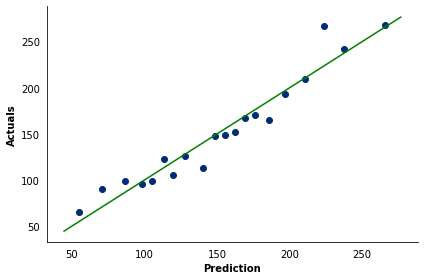

In [34]:
fig, plotdata = model_plots.act_vs_pred_plot(used_data = train_data, 
                             actual_var = 'disease_progression', 
                             pred_var = "stepwise_prediction", 
                             num_buckets = 20, with_count = False)

The number of bins can also be modified, to get a sense of the variance in the predictions, with the extreme being the same as a scatter plot

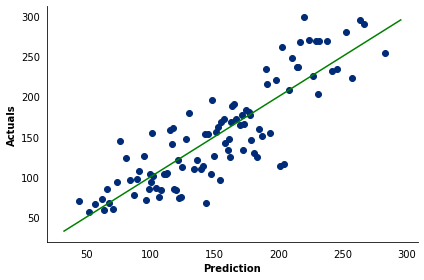

In [35]:
fig, plotdata = model_plots.act_vs_pred_plot(used_data = train_data, 
                             actual_var = 'disease_progression', 
                             pred_var = "stepwise_prediction", 
                             num_buckets = 100, with_count = False)

**Average and Predicted values by x-variable**

This groups the data based on a provided x-variable value, from low to high, and calculates the average actual (blue) and average predicted (red) for each bucket. A good model would have similar model errors throughout the x-variable values. If the actual vs. predicted values start to trail off, that may mean that a data transformation is necessary

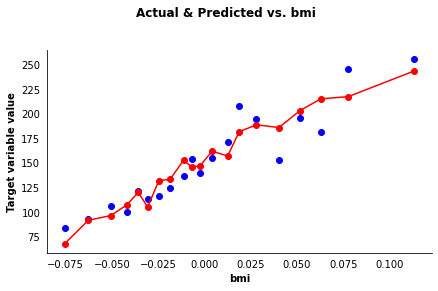

In [36]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "bmi", 
                                                        num_buckets=20, 
                                                        with_count = False)

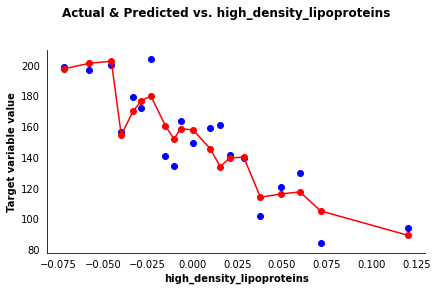

In [37]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "high_density_lipoproteins", 
                                                        num_buckets=20, 
                                                        with_count = False)

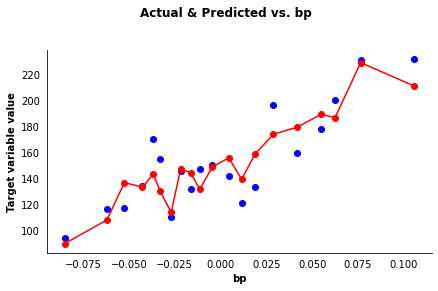

In [38]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "bp", 
                                                        num_buckets=20, 
                                                        with_count = False)

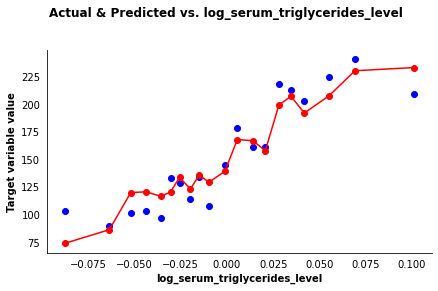

In [39]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "log_serum_triglycerides_level", 
                                                        num_buckets=20, 
                                                        with_count = False)

**Overall, the model predictions appear reasonable for all models, without resulting in large errors even for the smallest or largest x-variables** 

This means that the transformations, e.g. capping and flooring high_density_lipoproteins was not necessary, at least not for data representative of the training sample. 

**Average and Predicted values by variable not in the model**

This groups the data based on the value of an intuitive x-variable not in the model, from low to high, and calculates the average actual (blue) and average predicted (red) for each bucket. A good model is expected to perform well across this x-variable, as the relationship should be implicitly captured by other variables that are included in the model. If the model does not perform well, it may indicate that this x-variable should in some form be included in the model


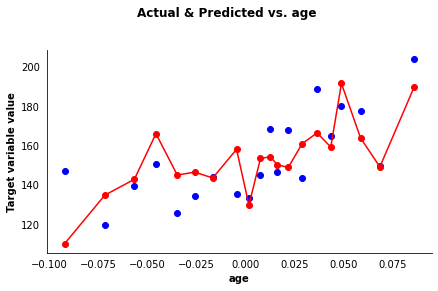

In [40]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "age", 
                                                        num_buckets=20, 
                                                        with_count = False)

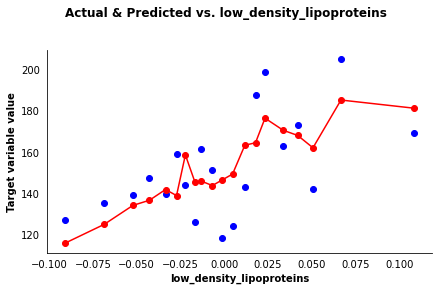

In [41]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "low_density_lipoproteins", 
                                                        num_buckets=20, 
                                                        with_count = False)

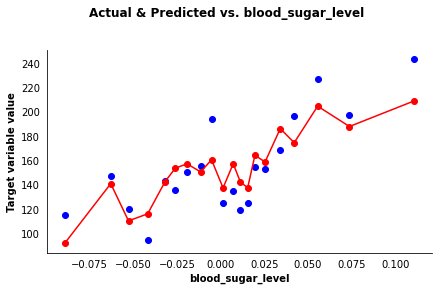

In [42]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "disease_progression", 
                                                        pred_var = "stepwise_prediction", 
                                                        x_var = "blood_sugar_level", 
                                                        num_buckets=20, 
                                                        with_count = False)

**None of the three x-variables above are in the model, yet the model captures the correlation with these variables** 

<a id="statistical_tests_plots"></a>

## Basic statistical tests and associated plots

Econometric regression models rely on a range of statistical assumptions to yield unbiased/consistent/efficient estimates and inference, and these assumptions tend to be more important for small to medium sized datasets. Here we test for a few common statistical assumptions:
* Model inference / Hypothesis test of coefficient significance (p-values of coefficients)
* Residual normality
* Homoscedasticity

In general sklearn does not provide capabilities in this space, and 'statsmodels' may be a better library: https://www.statsmodels.org/stable/index.html. A separate Notebook will be created to delve deeper into model testing.

**Model inference**

sklearn's regressions do not produce p-values for the coefficients. We have created extensions to sklearn that does produce p-values that relies on sklearn regressions.

In [43]:
X_train['intercept'] = 1  # Add intercept to the X_train data
stepwise_model_2 = sklearn_regression.LinearRegression().fit(X_train[['intercept']+stepwise_variables],y_train)
pd.DataFrame.from_dict({
    "Variables": ['intercept']+stepwise_variables,
    "Coefficients": stepwise_model_2.coef_,
    "SE": stepwise_model_2.se,
    "t-Stat": stepwise_model_2.t,
    "p-value": stepwise_model_2.p,
})

,Variables,Coefficients,SE,t-Stat,p-value
0,intercept,151.988840,3.178614,47.816078,0.000000e+00
1,high_density_lipoproteins,-253.286293,78.984657,-3.206778,1.485796e-03
2,log_serum_triglycerides_level,526.371365,79.869155,6.590421,1.942901e-10
3,bmi,556.951295,77.593919,7.177770,5.490275e-12
4,sex,-257.167538,72.857960,-3.529711,4.806020e-04
5,bp,304.261382,74.377032,4.090798,5.515612e-05


**If you had statsmodels, you would run the following**

In [44]:
# import statsmodels.api as sm
# statsmodel = sm.OLS(y_train, X_train[['intercept']+stepwise_variables]).fit()
# print(statsmodel.summary())

**Residual normality**

This checks whether residuals are normally distributed. It is not an important assumption for an OLS regression to be reliable, but is usually checked to make sure that the residuals are generally well-behaved.

*Shapiro-Wilks test* for residual normality is used below. The null-hypothesis is that the residuals are normally distributed, meaning that a value < 0.05 indicates non-normality

In [45]:
residuals = train_data["disease_progression"] - train_data['stepwise_prediction']
sc.stats.shapiro(residuals)

ShapiroResult(statistic=0.9959486722946167, pvalue=0.611939549446106)

*A histogram with normal distribution overlay*

If the residuals are normally distributed, the histogram would be close to the normal distribution overlay

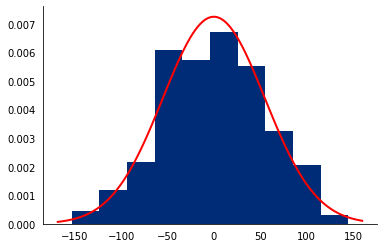

In [46]:
fig, ax = plt.subplots(1,1)
ax.hist(residuals, density=True)

# mean and standard deviation
mu, std = sc.stats.norm.fit(residuals) 

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = sc.stats.norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, color="red")
plt.show()

*QQ-plot*

A quantile-quantile plot compares two probability distributions by plotting their quantiles against each other. We can use the empirical distribution of the residuals and compare against the normal distribution

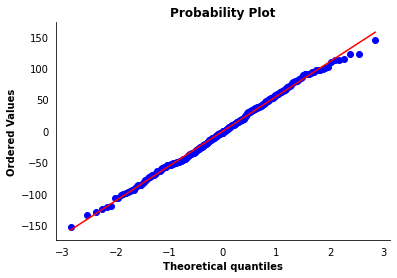

In [47]:
qq_plot = sc.stats.probplot(residuals, dist="norm", plot=matplotlib.pyplot)

*Homoscedasticity* refers to when the variance in model residuals are unrelated to the model's x-variables or predictions. When the variance of the residual is related to these variables, we have heteroscedasticity, which may bias the p-values of the model.

Here we use a simple statistical test called 'Breusch-Pagan' to test for relationship between residual variance and model variables. Since the mean of the residuals are 0, the variance is represented as the residual^2. The null hypothesis is that residuals are homoscedastic.

In [48]:
def breusch_pagan(residuals, X):

    residuals_squared = [i ** 2 for i in residuals]
    residuals_squared = np.array([residuals_squared]).T
    regression = linear_model.LinearRegression().fit(X, residuals_squared)
    r_squared = metrics.r2_score(y_true=residuals_squared, y_pred=regression.predict(X))
    test_statistic = len(residuals) * r_squared
    p_value = sc.stats.chi2.sf(test_statistic, np.shape(X)[1])
    return (test_statistic, p_value)

bp_stat, bp_pval = breusch_pagan(residuals, X_train)
bp_pval

0.04399117399833882

A p-value just below 5% indicates that there is mild heteroscedasticity. Potentially, robust p-value estimates would need to be generated